In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgar/anaconda3/envs/geo_env/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.1-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


# V1

## Download block polygons with census data

In [ ]:
year = 2010
state_id = '14'
folder_name = 'censo_mza'
table_name = f'censo_mza_{year}'
query = f"SELECT * FROM {folder_name}.{table_name} WHERE \"CVEGEO\" LIKE \'{state_id}%%\'"
block_pop = aup.gdf_from_query(query, geometry_col='geometry')
print(block_pop.shape)
block_pop.head(2)

In [ ]:
block_pop = block_pop.to_crs("EPSG:6372")
block_pop.columns = block_pop.columns.str.lower()

In [ ]:
block_pop.plot()

## Generate "centroids" with census data

In [ ]:
block_pop = block_pop.set_index('cvegeo')
real_not_centroid = gpd.GeoDataFrame(geometry=block_pop.representative_point())
centroid_block_pop = real_not_centroid.merge(block_pop, right_index=True, left_index=True)
centroid_block_pop.drop(columns=['geometry_y'], inplace=True)
centroid_block_pop.rename(columns={'geometry_x':'geometry'}, inplace=True)
centroid_block_pop = gpd.GeoDataFrame(centroid_block_pop, geometry='geometry')
print(centroid_block_pop.shape)
centroid_block_pop.head(2)

#### Revision

In [ ]:
centroid_block_pop.pobtot.sum()

In [ ]:
block_pop.pobtot.sum()

## Centroid to hex

### Download state municipalities

In [ ]:
state_id = '14'
folder_name = 'marco'
table_name = 'mpos_2020'
query = f"SELECT * FROM {folder_name}.{table_name} WHERE \"CVEGEO\" LIKE \'{state_id}%%\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')
print(mun_gdf.shape)
mun_gdf.head(2)

In [ ]:
mun_gdf = mun_gdf.dissolve()

In [ ]:
res = 8
hex_gdf_8 = aup.create_hexgrid(block_pop[['geometry']], res)
hex_gdf_8 = hex_gdf_8.set_crs("EPSG:4326")
print(hex_gdf_8.shape)
hex_gdf_8.head(2)

In [ ]:
res = 9
hex_gdf_9 = aup.create_hexgrid(mun_gdf, res)
hex_gdf_9 = hex_gdf_9.set_crs("EPSG:4326")
print(hex_gdf_9.shape)
hex_gdf_9.head(2)

### Group data

#### Delete filler columns

In [12]:
dlt_col = {2020:['cve_ent','cve_mun','cve_loc','cve_ageb',
           'cve_mza','ambito','tipomza','entidad',
           'nom_ent','mun','nom_mun','loc','ageb','mza'],
          2010:['codigo','geografico',
                'fechaact','geometria','institucio',
                'oid','entidad','nom_ent','mun','nom_mun',
                'loc','nom_loc','ageb','mza']}
centroid_block_pop.drop(columns=dlt_col[year], inplace=True)

In [13]:
centroid_block_pop = centroid_block_pop.to_crs("EPSG:4326")
centroid_block_pop = centroid_block_pop.reset_index()

In [14]:
string_columns = ['cvegeo']
avg_column = [
            "prom_hnv",
            "graproes",
            "graproes_f",
            "graproes_m",
            "prom_ocup",
            "pro_ocup_c",
        ]

wgt_dict = { "prom_hnv":'pobtot',
            "graproes":'pobtot',
            "graproes_f":'pobfem',
            "graproes_m":'pobmas',
            "prom_ocup":'tvivparhab',
            "pro_ocup_c":'tvivparhab'
           }

In [15]:
res = 8

hex_socio_df = aup.socio_points_to_polygon(
    hex_gdf_8,
    centroid_block_pop,
    f'hex_id_{res}',
    string_columns,
    wgt_dict=wgt_dict,
    avg_column=avg_column,
)
print(hex_socio_df.shape)
hex_socio_df.head(2)

(1176, 191)


,pobtot,pobmas,pobfem,p_0a2,p_0a2_m,p_0a2_f,p_3ymas,p_3ymas_m,p_3ymas_f,p_5ymas,...,vph_radio,vph_tv,vph_refri,vph_lavad,vph_autom,vph_pc,vph_telef,vph_cel,vph_inter,hex_id_8
0,4899.0,2416.0,2483.0,169.0,49.0,46.0,4626.0,2279.0,2347.0,4449.0,...,1162.0,1305.0,1264.0,1158.0,977.0,612.0,759.0,1124.0,507.0,88484a481dfffff
1,3484.0,1698.0,1770.0,225.0,88.0,89.0,3071.0,1493.0,1576.0,2863.0,...,815.0,967.0,968.0,903.0,907.0,671.0,623.0,929.0,570.0,88485bb2d7fffff


In [16]:
hex_socio_df.pobtot.sum()

2893127.0

In [19]:
hex_gdf_socio = hex_gdf_9.merge(hex_socio_df, on=f'hex_id_{res}')
hex_gdf_socio.head(2)

,hex_id_9,geometry,nom_loc,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3ymas,...,vph_telef,vph_cel,vph_inter,vph_stvp,vph_spmvpi,vph_cvj,vph_sinrtv,vph_sinltc,vph_sincint,vph_sintic
0,894988d9347ffff,"POLYGON ((-102.32849 21.90442, -102.32725 21.9...",AguascalientesAguascalientesAguascalientes,101.0,48.0,53.0,4.0,3.0,0.0,96.0,...,21.0,32.0,32.0,21.0,26.0,14.0,0.0,0.0,0.0,0.0
1,89498e22b93ffff,"POLYGON ((-102.14663 22.01696, -102.14538 22.0...",JaltomateJaltomate,131.0,72.0,59.0,7.0,4.0,3.0,124.0,...,0.0,30.0,11.0,10.0,0.0,3.0,0.0,0.0,21.0,0.0


In [20]:
hex_gdf_socio['dens_pob_ha'] = hex_gdf_socio.pobtot / (hex_gdf_socio.to_crs("EPSG:6372").area)

<AxesSubplot:>

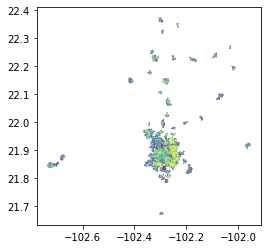

In [23]:
hex_gdf_socio.plot('dens_pob_ha', 'viridis')

# V2

## Download municipality polygons and census data at block level from database

In [2]:
df = pd.read_json("../scripts/Metropolis_CVE.json")

year = 2010

#Folder names from database
block_schema = 'censo_mza'
block_folder = f'censo_mza_{year}'
mpos_schema = 'marco'
mpos_folder = f'mpos_{year}'

c = 'Laguna'
# Creates empty GeoDataFrame to store specified municipality polygons, infonavit_grid and hexbins
mun_gdf = gpd.GeoDataFrame()
block_pop = gpd.GeoDataFrame()
# Iterates over municipality codes for each metropolitan area or capital
for i in range(len(df.loc["mpos", c])):
    # Extracts specific municipality code
    m = df.loc["mpos", c][i]
    # Downloads municipality polygon according to code
    query = f"SELECT * FROM {mpos_schema}.{mpos_folder} WHERE \"CVEGEO\" LIKE \'{m}\'"
    mun_gdf = mun_gdf.append(aup.gdf_from_query(query, geometry_col='geometry'))
    #Creates query to download block data
    query = f"SELECT * FROM {block_schema}.{block_folder} WHERE \"CVEGEO\" LIKE \'{m}%%\'"
    block_pop = block_pop.append(aup.gdf_from_query(query, geometry_col='geometry'))
    
mun_gdf = mun_gdf.to_crs("EPSG:4326")
block_pop = block_pop.to_crs("EPSG:4326")

In [3]:
print(mun_gdf.shape)
mun_gdf.head(2)

(5, 6)


,CVE_ENT,CVE_MUN,NOM_MUN,OID,geometry,CVEGEO
0,05,009,Francisco I. Madero,2279,"POLYGON ((-103.13447 26.72362, -103.05045 26.6...",05009
0,05,017,Matamoros,2252,"POLYGON ((-103.22252 25.75687, -103.22099 25.7...",05017


In [4]:
print(block_pop.shape)
block_pop.head(2)

(20798, 206)


,CVEGEO,CODIGO,GEOGRAFICO,FECHAACT,GEOMETRIA,INSTITUCIO,OID,geometry,entidad,nom_ent,...,vph_snbien,vph_radio,vph_tv,vph_refri,vph_lavad,vph_autom,vph_pc,vph_telef,vph_cel,vph_inter
0,0500900010954035,LA_6635,MANZANA,12/2007,ÁREA,INEGI,None,"POLYGON ((-103.25942 25.77848, -103.25890 25.7...",5,Coahuila de Zaragoza,...,0,5,6,4,5,3,0,0,5,0
1,0500900010583056,LA_6635,MANZANA,06/2009,ÁREA,INEGI,None,"POLYGON ((-103.26480 25.76425, -103.26442 25.7...",5,Coahuila de Zaragoza,...,0,0,3,3,0,3,0,0,0,0


In [5]:
block_pop = block_pop.to_crs("EPSG:6372")
block_pop.columns = block_pop.columns.str.lower()
block_pop = block_pop.replace('N/D',np.nan)

<AxesSubplot:>

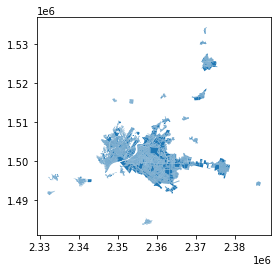

In [6]:
block_pop.plot()

## Calculate centroid

In [7]:
block_pop = block_pop.set_index('cvegeo')
real_not_centroid = gpd.GeoDataFrame(geometry=block_pop.representative_point())
centroid_block_pop = real_not_centroid.merge(block_pop, right_index=True, left_index=True)
centroid_block_pop.drop(columns=['geometry_y'], inplace=True)
centroid_block_pop.rename(columns={'geometry_x':'geometry'}, inplace=True)
centroid_block_pop = gpd.GeoDataFrame(centroid_block_pop, geometry='geometry')
print(centroid_block_pop.shape)
centroid_block_pop.head(2)

(20798, 205)


,geometry,codigo,geografico,fechaact,geometria,institucio,oid,entidad,nom_ent,mun,...,vph_snbien,vph_radio,vph_tv,vph_refri,vph_lavad,vph_autom,vph_pc,vph_telef,vph_cel,vph_inter
cvegeo,,,,,,,,,,,,,,,,,,,,,
0500900010954035,POINT (2374277.594 1525911.015),LA_6635,MANZANA,12/2007,ÁREA,INEGI,None,5,Coahuila de Zaragoza,9,...,0,5,6,4,5,3,0,0,5,0
0500900010583056,POINT (2373734.444 1524353.561),LA_6635,MANZANA,06/2009,ÁREA,INEGI,None,5,Coahuila de Zaragoza,9,...,0,0,3,3,0,3,0,0,0,0


### Checking for lost population data in centroid

In [8]:
centroid_block_pop.pobtot.sum()

1097873

In [9]:
block_pop.pobtot.sum()

1097873

## Group census data at hexagons

### Create hexagons for municipality polygons

In [10]:
res = 8
mun_buffer = gpd.GeoDataFrame(geometry=mun_gdf.to_crs("EPSG:6372").dissolve().buffer(2500))
mun_buffer = mun_buffer.to_crs("EPSG:4326")
hex_gdf_8 = aup.create_hexgrid(mun_buffer, res)
hex_gdf_8 = hex_gdf_8.to_crs("EPSG:4326")
print(hex_gdf_8.shape)
hex_gdf_8.head(2)

(11420, 2)


,hex_id_8,geometry
0,8848acc2b3fffff,"POLYGON ((-103.30007 26.18839, -103.29533 26.1..."
1,8848acc2a5fffff,"POLYGON ((-103.26239 26.16790, -103.25765 26.1..."


In [11]:
dlt_col = {2020:['cve_ent','cve_mun','cve_loc','cve_ageb',
           'cve_mza','ambito','tipomza','entidad','nom_loc',
           'nom_ent','mun','nom_mun','loc','ageb','mza'],
          2010:['codigo','geografico',
                'fechaact','geometria','institucio',
                'oid','entidad','nom_ent','mun','nom_mun',
                'loc','nom_loc','ageb','mza']}
centroid_block_pop.drop(columns=dlt_col[year], inplace=True)

In [12]:
centroid_block_pop = centroid_block_pop.to_crs("EPSG:4326")
centroid_block_pop = centroid_block_pop.reset_index()

In [13]:
string_columns = ['cvegeo']
avg_column = [
            "prom_hnv",
            "graproes",
            "graproes_f",
            "graproes_m",
            "prom_ocup",
            "pro_ocup_c",
        ]

wgt_dict = { "prom_hnv":'pobtot',
            "graproes":'pobtot',
            "graproes_f":'pobfem',
            "graproes_m":'pobmas',
            "prom_ocup":'tvivparhab',
            "pro_ocup_c":'tvivparhab'
           }

In [14]:
res = 8

hex_socio_df = aup.socio_points_to_polygon(
    hex_gdf_8,
    centroid_block_pop,
    f'hex_id_{res}',
    string_columns,
    wgt_dict=wgt_dict,
    avg_column=avg_column,
)
print(hex_socio_df.shape)
hex_socio_df.head(2)

(454, 191)


,pobtot,pobmas,pobfem,p_0a2,p_0a2_m,p_0a2_f,p_3ymas,p_3ymas_m,p_3ymas_f,p_5ymas,...,vph_radio,vph_tv,vph_refri,vph_lavad,vph_autom,vph_pc,vph_telef,vph_cel,vph_inter,hex_id_8
0,3974.0,1918.0,1946.0,200.0,71.0,54.0,3585.0,1772.0,1813.0,3437.0,...,733.0,907.0,840.0,710.0,428.0,175.0,176.0,659.0,88.0,8848126a2dfffff
1,2262.0,1059.0,1149.0,152.0,58.0,59.0,2033.0,972.0,1061.0,1935.0,...,440.0,537.0,518.0,434.0,321.0,120.0,114.0,423.0,39.0,8848126a61fffff


In [15]:
hex_socio_df.pobtot.sum()

1097873.0